In [1]:
# Uncomment the lines below if your IPython and notebook config files do not include them.
#%pylab inline
#from __future__ import division
from IPython import display
import lmfit

We are currently planning to show only the data for the 9-element chip.

Add analysis of the high-frequency resonance of the 9-element chip.

Initial data for the 9-element chip, taken with the oscilloscope:
http://nbviewer.ipython.org/github/gitj/notebooks/blob/master/2014-06-19-sc3x3-tauqp-red-led.ipynb

Values derived from fits to the data for the same 9-element chip:

In [2]:
tau_9_good = np.load('nine-element_pulse_good.npy')
tau_9_good[6] = False # This point has neighbors at 10 mK on either side and doesn't add much.
T_9 = np.load('nine-element_pulse_T.npy')[tau_9_good]
tau_9 = np.load('nine-element_pulse_tau.npy')[tau_9_good]
tau_9_error = np.load('nine-element_pulse_tau_error.npy')[tau_9_good]

Analysis of the high-frequency resonance of the 20-element chip: http://nbviewer.ipython.org/github/danielflanigan/notebooks/blob/master/mkid/2014-07-15_tau_qp_resonance.ipynb

Light data for the 20-element chip: http://nbviewer.ipython.org/github/danielflanigan/notebooks/blob/master/mkid/2014-07-10_tau_qp_versus_bath_temperature.ipynb

In [3]:
light_pulse_T_stage = np.load('light_pulse_T_stage.npy')
light_pulse_fast_tau = np.load('light_pulse_fast_tau.npy')
light_pulse_slow_tau = np.load('light_pulse_slow_tau.npy')
# Select either the fast or slow time constant.
light_pulse_use_slow = [0, 1, 2, 3, 4, 6, 7]
light_pulse_use_fast = [8, 9]

All temperatures are in kelvin, all time constants are in $\mu \mathrm{s}$, and all densities are in $\mu \mathrm{m}^{-3}$.

These are all in SI units:

In [4]:
from scipy.constants import e, h, k

From Omid's thesis, in $\mu \mathrm{m}^{-3} \, \mathrm{eV}^{-1}$:

In [5]:
N_0_Al = 1.72e10

The Boltzmann constant, in $\mathrm{eV} \, \mathrm{K}^{-1}$:

In [6]:
k_eV = k / e

Our measured $T_c$:

In [7]:
T_c = 1.46

The superconducting gap $\Delta$ at zero temperature from BCS theory, in eV:

In [8]:
Delta = 1.76 * k_eV * T_c

The thermal quasiparticle density, in $\mu \mathrm{m}^{-3}$:

In [9]:
def thermal_quasiparticle_density(T):
    return 2 * N_0_Al * (2 * np.pi * k_eV * T * Delta)**(1/2) * np.exp(-Delta / (k_eV * T))

The model is
\begin{equation*}
\tau_{qp}(T)
  =
  \frac{\tau_{max}}{1 + n_{qp}(T) / n_*}.
\end{equation*}

In [10]:
def model(params, T):
    tau_max = params['tau_max'].value
    n_star = params['n_star'].value
    n_qp = thermal_quasiparticle_density(T)
    tau_qp = tau_max / (1 + n_qp / n_star)
    return tau_qp

def residual(params, T, data, errors=1):
    return (model(params, T) - data) / errors

def initial(tau_max=500, n_star=400):
    p = lmfit.Parameters()
    p.add('tau_max', value=tau_max, min=0)
    p.add('n_star', value=n_star, min=0)
    return p

In [11]:
fit = lmfit.minimize(residual, initial(), args=[T_9, tau_9, tau_9_error])
lmfit.report_fit(fit.params)

[[Variables]]
     n_star:      362.536567 +/- 37.695562 (10.40%) initial =  400.000000
     tau_max:     485.832388 +/- 16.196911 (3.33%) initial =  500.000000
[[Correlations]] (unreported correlations are <  0.100)
    C(n_star, tau_max)           = -0.566 


In [12]:
TT = np.linspace(0.001, 0.4, 1e3)

In [13]:
lines = {'markersize': 3}
font = {'family': 'serif',
#        'serif': 'Times New Roman',
        'serif': 'Times',
        'size': 11}
text = {'usetex': 'True'}
axes = {'linewidth': 0.5,
        'titlesize': 'medium',
        'labelsize': 'small'}
ticks = {'major.size': 3,
         'major.width': 0.5,
         'labelsize': 'small'}
grid = {'color': 'gray'}
legend = {'numpoints': 1,
          'fontsize': 'small',
          'frameon': 'False',
          'handletextpad': 0.2}
figure = {'figsize': (3, 3),
          'dpi': 300,
          'facecolor': 'white',
          'subplot.left': 0.2,
          'subplot.right': 0.92,
          'subplot.bottom': 0.15,
          'subplot.top': 0.92}
savefig = {'dpi': 300}
plt.rcdefaults()
plt.rc('lines', **lines)
plt.rc('font', **font)
plt.rc('text', **text)
plt.rc('axes', **axes)
plt.rc(('xtick', 'ytick'), **ticks)
plt.rc('grid', **grid)
plt.rc('legend', **legend)
plt.rc('figure', **figure)
plt.rc('savefig', **savefig)

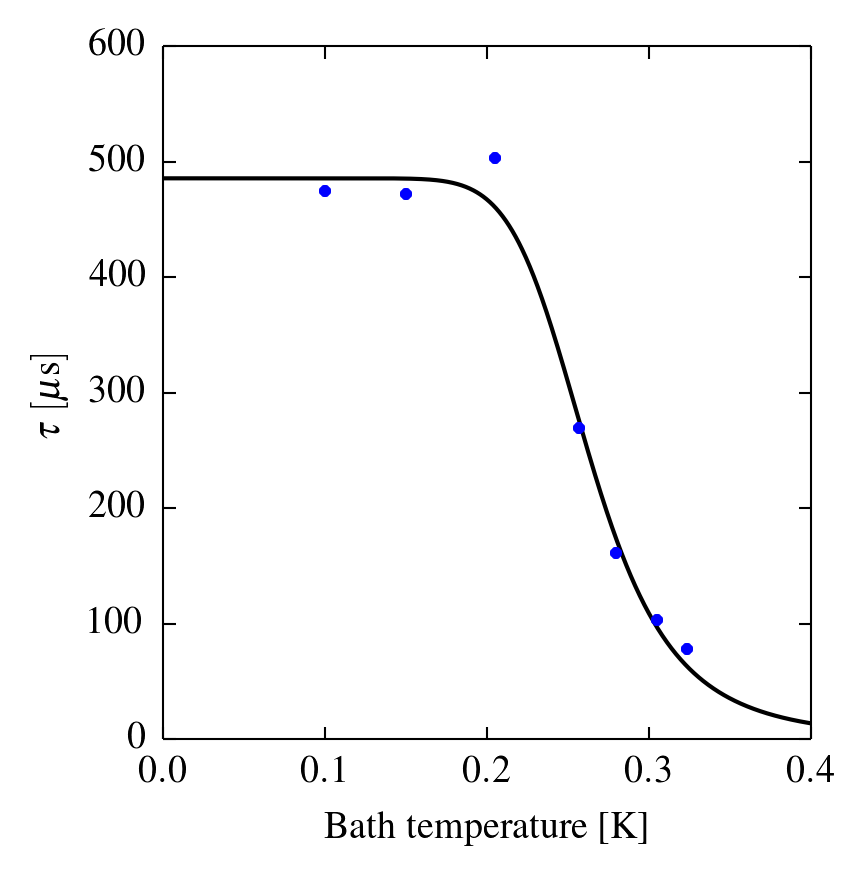

In [14]:
fig, ax = plt.subplots()
ax.plot(TT, model(fit.params, TT), linestyle='-', color='black', linewidth=1)
#ax.plot(light_pulse_T_stage[light_pulse_use_fast], light_pulse_fast_tau[light_pulse_use_fast], linestyle='None', color='red', markeredgecolor='None', marker='s',
#        label='20-element array')
#ax.plot(light_pulse_T_stage[light_pulse_use_slow], light_pulse_slow_tau[light_pulse_use_slow], linestyle='None', color='red', markeredgecolor='None', marker='s')
ax.plot(T_9, tau_9, linestyle='None', color='blue', markeredgecolor='None', marker='o')
xticks = np.linspace(0, 0.4, 5)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_xticks(xticks)
ax.set_ylim(0, 600)
ax.set_xlabel('Bath temperature [K]')
ax.set_ylabel(r'$\tau \; [\mu \mathrm{s}]$')
#ax.legend(loc='lower left')
fig.savefig('tau_qp_vs_bath_temperature.pdf')
display.clear_output()
display.display(fig)